Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\subprocess.py", line 1612, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap

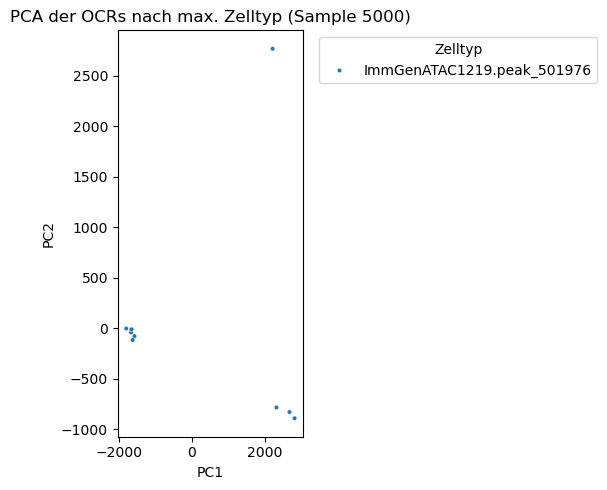

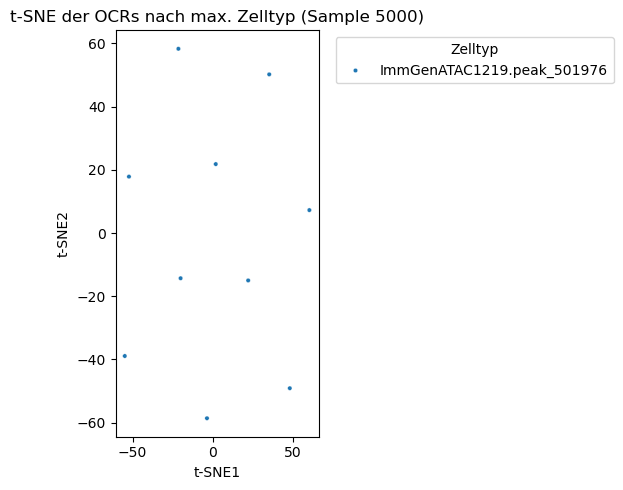

c:\Users\janna\miniconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


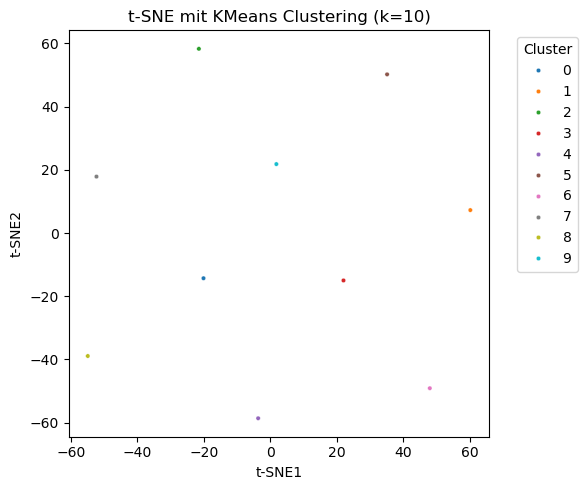

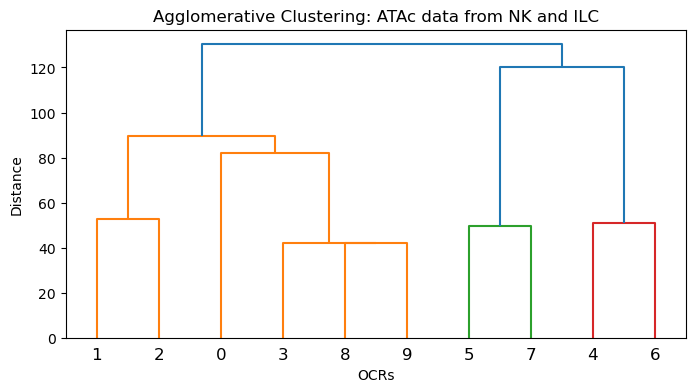

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt

# CSV einlesen
df_raw = pd.read_csv("data/ImmGenATAC18_AllOCRsInfo.csv", header=0, quotechar='"', encoding='latin1')

# Zelltypen-Spalten
celltype_cols = [
    "ILC2.SI", "ILC3.NKp46-CCR6-.SI", "ILC3.NKp46+.SI", "ILC3.CCR6+.SI",
    "NK.27+11b-.BM", "NK.27+11b+.BM", "NK.27-11b+.BM",
    "NK.27+11b-.Sp", "NK.27+11b+.Sp", "NK.27-11b+.Sp"
]

# OCR IDs als Index
ocr_ids = df_raw.iloc[:, 0].values
df_expr = df_raw[celltype_cols]
df_expr.index = ocr_ids
df_expr.index.name = "OCR_ID"
# Transponieren
df_expr = df_expr.T
df_expr.columns = ocr_ids
df_expr.index.name = "Celltype"


# Sample von 5000 OCRs
#df_sample = df_expr.sample(n=5000, random_state=42)

# Maximaler Zelltyp je OCR (für Farbgebung)
max_celltypes = df_expr.idxmax(axis=1)

# PCA
pca = PCA(n_components=9)
pca_result = pca.fit_transform(df_expr)

# t-SNE
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
tsne_result = tsne.fit_transform(df_expr)

# PCA Plot mit Färbung nach Zelltyp
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=max_celltypes, s=10, palette="tab10")
plt.title("PCA der OCRs nach max. Zelltyp (Sample 5000)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Zelltyp")
plt.tight_layout()
plt.show()

# t-SNE Plot mit Färbung nach Zelltyp
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=max_celltypes, s=10, palette="tab10")
plt.title("t-SNE der OCRs nach max. Zelltyp (Sample 5000)")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Zelltyp")
plt.tight_layout()
plt.show()

from sklearn.cluster import KMeans

# Anzahl der Cluster 
n_clusters = 10

# KMeans Clustering auf t-SNE-Daten
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(tsne_result)

# Plot t-SNE mit KMeans Clustern
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=cluster_labels, palette="tab10", s=10)
plt.title(f"t-SNE mit KMeans Clustering (k={n_clusters})")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Z = linkage(tsne_result, method='ward')

# Plots dendrogram
plt.figure(figsize=(8, 4))
dendrogram(Z)
plt.title('Agglomerative Clustering: ATAc data from NK and ILC')
plt.xlabel('OCRs')
plt.ylabel('Distance')
plt.show()